In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import FATS
import warnings
from scipy.optimize import OptimizeWarning
import pickle
warnings.filterwarnings("ignore", category=OptimizeWarning)


c:\Users\gltut\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Reading raw data

In [ ]:
path = 'LC/LS_agn_cutouts_masked_Jan20'


rows = []
epochs_lst = []

for obs in os.listdir(path):
    print(obs)

    if obs != '.DS_Store':
        count = 0
        times = []

        for visit in os.listdir(f'{path}/{obs}'):
            epoch = int(visit[5:7])

            if int(epoch) != 0:
                times.append(epoch)
                hdu = fits.open(f'{path}/{obs}/{visit}')
                d = hdu[0].data
                d_exp = d.reshape(51, 51, 1)
                if count == 0:
                    result = d_exp
                    
                else:
                    result = np.concatenate((result, d_exp), axis=-1)
                
                count += 1
                
        rows.append(result)
        epochs_lst.append(times)
        
df_agn = pd.DataFrame(data = {'RAW':rows,
                              'days':epochs_lst})


path = 'LC/LS_non_agn_cutouts_masked_Jan20'
rows = []
epochs_lst = []

for obs in os.listdir(path):
    print(obs)

    if obs != '.DS_Store':
        count = 0
        times = []

        for visit in os.listdir(f'{path}/{obs}'):
            epoch = int(visit[5:7])

            if int(epoch) != 0:
                times.append(epoch)
                hdu = fits.open(f'{path}/{obs}/{visit}')
                d = hdu[0].data
                d_exp = d.reshape(51, 51, 1)
                if count == 0:
                    result = d_exp
                    
                else:
                    result = np.concatenate((result, d_exp), axis=-1)
                
                count += 1
                
        rows.append(result)
        epochs_lst.append(times)
                
df_noagn = pd.DataFrame(data = {'RAW':rows,
                              'days':epochs_lst})


In [ ]:
times = pd.read_csv('DeCicco_et_al2022_date_osservazioni.csv')
dict_days = dict(zip(times['ID'],times['time(days)']))

def get_days(value):
    days = []
    for i in value:
        days.append(dict_days[i])
    return days


df_agn['days'] = df_agn['days'].apply(get_days)
df_noagn['days'] = df_noagn['days'].apply(get_days)


df = pd.concat([df_agn, df_noagn], axis = 0)
df = df.reset_index(drop = 1)

# Feature extraction

In [ ]:
featurelist = ['Amplitude', 'AndersonDarling', 'Autocor_length', 'Con', 'Eta_e', 'FluxPercentileRatioMid20', 
 'FluxPercentileRatioMid35', 'FluxPercentileRatioMid50', 'FluxPercentileRatioMid65', 'FluxPercentileRatioMid80',
 'Gskew', 'LinearTrend', 'MaxSlope', 'Mean', 'Meanvariance', 'MedianAbsDev', 'MedianBRP', 'PairSlopeTrend', 'PercentAmplitude', 
 'PercentDifferenceFluxPercentile', 'Q31', 'Rcs', 'Skew', 'SmallKurtosis', 'SlottedA_length' , 'Std', 'PeriodLS', 'Period_fit', 
 'Psi_CS', 'Psi_eta', 'StructureFunction_index_21', 'StructureFunction_index_31', 'StructureFunction_index_32',
 'Freq1_harmonics_amplitude_0', 'Freq1_harmonics_amplitude_1', 'Freq1_harmonics_amplitude_2', 'Freq1_harmonics_amplitude_3', 
 'Freq1_harmonics_rel_phase_0', 'Freq1_harmonics_rel_phase_1', 'Freq1_harmonics_rel_phase_2', 'Freq1_harmonics_rel_phase_3', 
 'Freq2_harmonics_amplitude_0', 'Freq2_harmonics_amplitude_1', 'Freq2_harmonics_amplitude_2', 'Freq2_harmonics_amplitude_3', 
 'Freq2_harmonics_rel_phase_0', 'Freq2_harmonics_rel_phase_1', 'Freq2_harmonics_rel_phase_2', 'Freq2_harmonics_rel_phase_3', 
 'Freq3_harmonics_amplitude_0', 'Freq3_harmonics_amplitude_1', 'Freq3_harmonics_amplitude_2', 'Freq3_harmonics_amplitude_3', 
 'Freq3_harmonics_rel_phase_0', 'Freq3_harmonics_rel_phase_1', 'Freq3_harmonics_rel_phase_2', 'Freq3_harmonics_rel_phase_3']

In [ ]:
def fun_np(magnitudes, times):
    a = FATS.FeatureSpace(Data= ['magnitude', 'time'], featureList= featurelist)
    b =  a.calculateFeature(np.array([magnitudes, times]))
    return b.result()


def apply_fun(row):
    mags, times = row['RAW'], row['days']
    row['list + car'] = np.apply_along_axis(fun_np, axis = 2, arr = mags, times = times)
    return row

df_result = df.apply(apply_fun, axis = 1)

with open('data_ulisse/complete_df.pkl', 'wb') as file:
    pickle.dump(df_result, file)


In [ ]:
with open('complete_df.pkl', 'rb') as file:
    df = pickle.load(file)

df = df.drop('SlottedA_length', axis = 1 )
for i in df.columns.values:
    for j in range(2675):
        try:
            if df[i][j].shape == (51, 51, 1):
                df[i][j] = df[i][j][:,:,0]
        except:
            print('ERROR')
            print(i, j)

with open(r'true_df.pkl', 'wb') as file:
    pickle.dump(df, file)

In [ ]:
def cut_imgs(img):
    new_shape = 21

    # Plot + colorbar
    start_index = (img.shape[0] - new_shape) // 2
    sub_array = img[start_index:start_index+new_shape, start_index:start_index+new_shape]
    return sub_array

for col in df.columns.values[:-1]:
    df[col] = df[col].apply(cut_imgs)
    
with open(r'true_df_21.pkl', 'wb') as file:
    pickle.dump(df, file)

# XGBoost data

In [ ]:
def get_mask(img, quant):
    threshold = np.quantile(img, quant)

    # Create a mask for values greater than the threshold
    mask = img > threshold
    return mask


with open('complete_df.pkl', 'rb') as file:
    tst = pickle.load(file)



rows = []
for index in range(tst.shape[0]):
    if index % 100 == 0:
        print(index)
    mask = get_mask(tst['Median'][index], 0.9)
    for i in range(51):
        for j in range(51):
            if mask[i, j] == True:
                row = []
                for col in tst.columns.values[:-1]:
                    try:
                        row.append(tst[col][index][i, j])
                    except:
                        row.append(None)
                row.append(tst['AGN'][index])
                rows.append(row)


xgb_df = pd.DataFrame(data = rows, columns = tst.columns.values)

with open(r'C:\Users\gltut\Desktop\Thesis2.0\data_xgboost\complete_df_xgb.pkl', 'wb') as file:
    pickle.dump(xgb_df, file)

# Some visualization

In [2]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [33]:
with open('true_df_21.pkl', 'rb') as file:
    df = pickle.load(file)

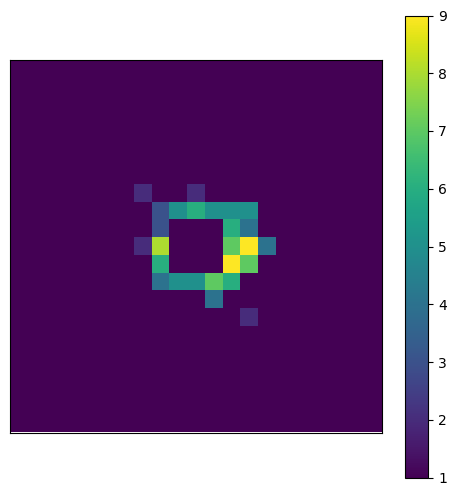

In [35]:
import plotly.graph_objects as go

img = df['Autocor_length'][187]
plt.figure(figsize = (6, 6))
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()


# Create X and Y indices
x = np.arange(img.shape[0])
y = np.arange(img.shape[1])
x, y = np.meshgrid(x, y)

# Create the 3D surface plot
fig = go.Figure(data=[go.Surface(z=img, x=x, y=y, colorscale='Viridis')])

# Add labels and title
fig.update_layout(
    title='3D Surface Plot of 21x21 Array',
    scene=dict(
        xaxis=dict(showticklabels=False),
        yaxis=dict(showticklabels=False),
        zaxis=dict(title='Autocor_length')
    )
)

# Show the plot
fig.show()

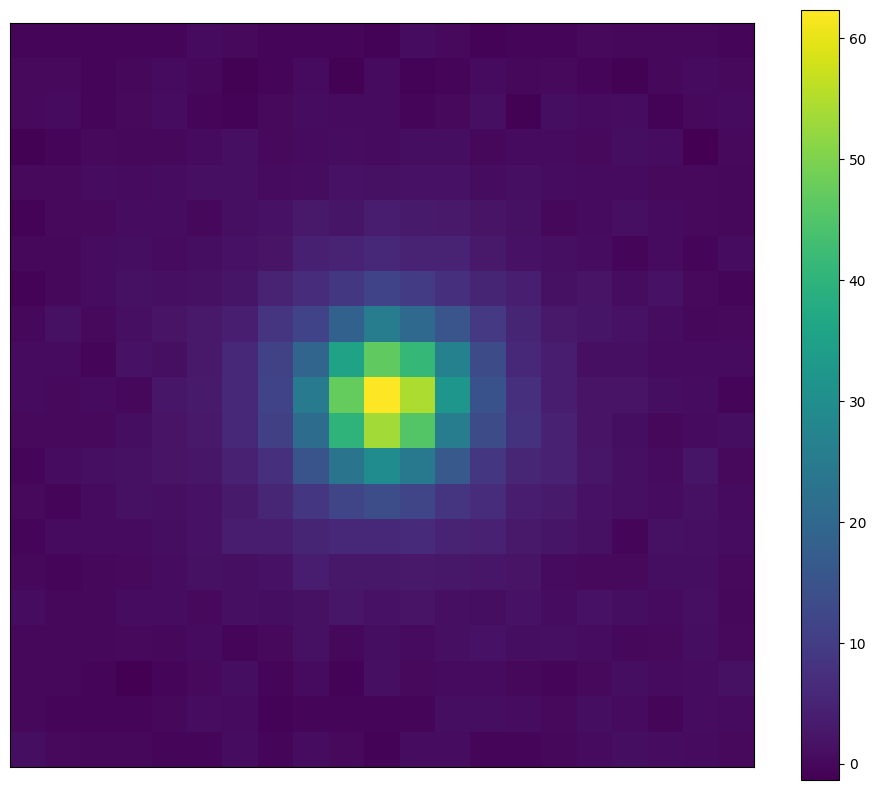

In [36]:
import plotly.graph_objects as go

img = df['Median'][187]
plt.figure(figsize = (12, 10))
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()


# Create X and Y indices
x = np.arange(img.shape[0])
y = np.arange(img.shape[1])
x, y = np.meshgrid(x, y)

# Create the 3D surface plot
fig = go.Figure(data=[go.Surface(z=img, x=x, y=y, colorscale='Viridis')])

# Add labels and title
fig.update_layout(
    title='3D Surface Plot of 21x21 Array',
    scene=dict(
        xaxis=dict(showticklabels=False),
        yaxis=dict(showticklabels=False),
        zaxis=dict(title='Autocor_length')
    )
)

# Show the plot
fig.show()

In [24]:
with open(r'C:\Users\gltut\Desktop\Thesis2.0\Datasets\raw_df.pkl', 'rb') as file:
    df = pickle.load(file)

<Axes: >

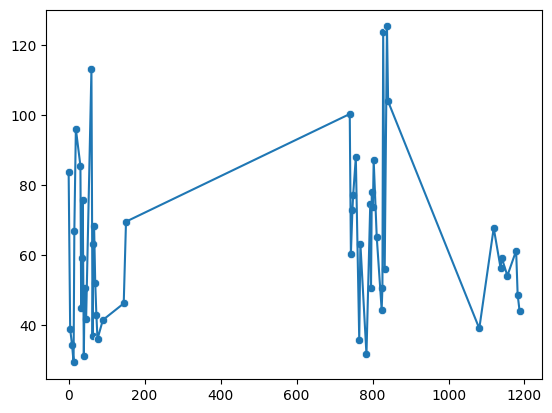

In [31]:
img_tst = df['RAW'][178]
days_tst = df['days'][178]
sns.lineplot(x = days_tst, y = img_tst[27, 26, :])
sns.scatterplot(x = days_tst, y = img_tst[27, 26, :])